<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Projeto 3 - Ciência dos Dados</p>

Alunos:
<ul style="font-family:monospace">
    <li>Cicero Tiago Carneiro Valentim</li>
    <li>Luiz Felipe Lazzaron</li>
    <li>Marcos Vinícius da Silva</li>
    <li>Thalia Loiola Silva</li>
</ul>

In [1]:
# pandas
import pandas as pd
from pandas.tools.plotting import scatter_matrix

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# time (calular tempo gasto nos modelos)
from time import time

# warnings (deixar de poluir o documento com warnings)
import warnings
warnings.filterwarnings('ignore')

# scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

# scikit-learn modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [3]:
airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Limpeza dos dados</p>

In [4]:
# limpar colunas desnecessárias:
airbnb = airbnb.drop(columns=["id","name","host_name","minimum_nights","last_review", 'calculated_host_listings_count'])

In [5]:
airbnb.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,reviews_per_month,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,0.21,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,0.38,355


In [6]:
# analisar a coluna "room_type", pois ela parece ser relevante para a análise
airbnb["room_type"].value_counts() # Essa coluna mostrou bastante potencial como variável qualitativa

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

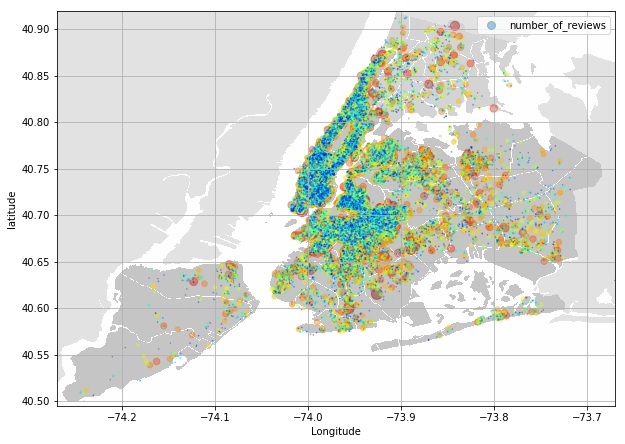

In [7]:
new_york = mpimg.imread('New_York_City_.png',0)

airbnb.sort_values('number_of_reviews', ascending=False).plot(kind="scatter", x='longitude', y='latitude', marker="o",
            s=(airbnb["number_of_reviews"]/5), grid=True, colorbar=False, c=np.log(airbnb["number_of_reviews"]), 
            cmap=plt.get_cmap("jet"), figsize=(10,10), label="number_of_reviews", alpha=0.4)

plt.imshow(new_york, alpha=0.4, cmap=plt.get_cmap("jet"), extent=[-74.27, -73.67, 40.495, 40.92])
eixo_x = np.linspace(min(airbnb.longitude), max(airbnb.longitude), 0.3)
plt.xlabel("Longitude")
plt.legend()
plt.title("")
plt.show()

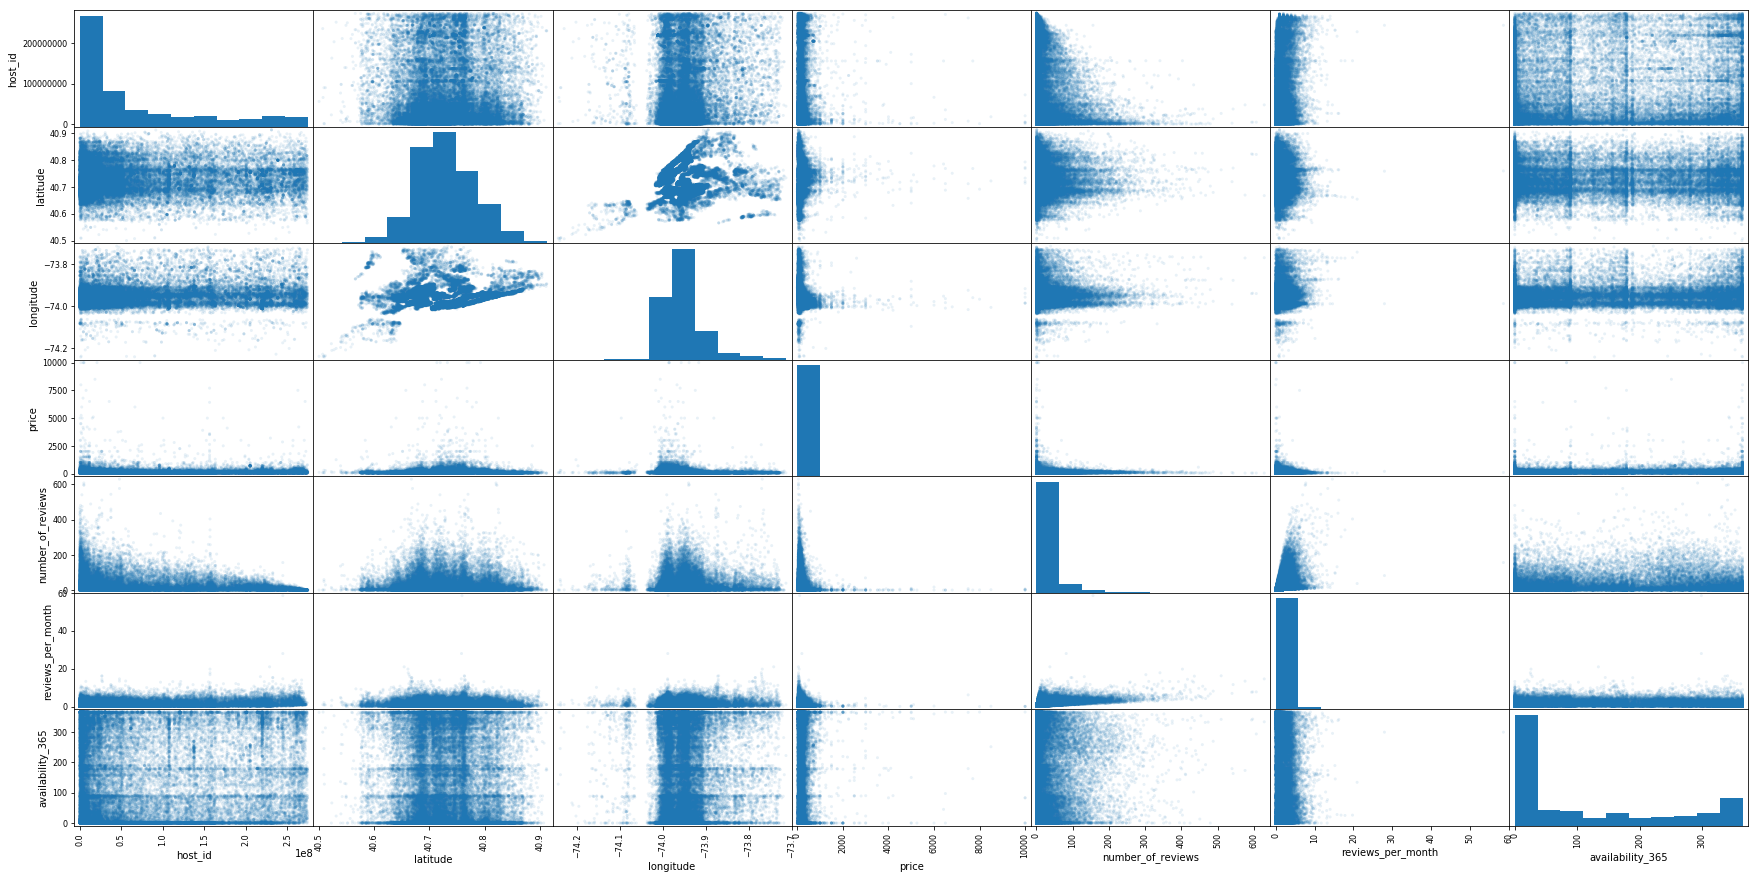

In [8]:
scatter_matrix(airbnb[airbnb.columns], figsize=(30,15), alpha=0.1)
plt.show();

<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Separação em treinamento e teste</p>

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(airbnb, airbnb["room_type"]):
    strat_train_set = airbnb.loc[train_index]
    strat_test_set = airbnb.loc[test_index]

In [10]:
strat_train_set.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,reviews_per_month,availability_365
12776,50364039,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,130,67,1.57,252
38717,107434423,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,312,0,NaN,38
35008,12926593,Manhattan,West Village,40.73202,-74.00348,Private room,150,2,0.21,56
266,312722,Brooklyn,Williamsburg,40.70690,-73.95467,Private room,60,14,0.14,362
38787,49282603,Brooklyn,Bedford-Stuyvesant,40.69054,-73.92801,Entire home/apt,75,4,0.64,10


In [11]:
airbnb = strat_train_set.drop("price", axis=1)
airbnb_labels = strat_train_set["price"].copy()

In [12]:
airbnb.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,number_of_reviews,reviews_per_month,availability_365
12776,50364039,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,67,1.57,252
38717,107434423,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,0,NaN,38


In [13]:
airbnb.shape, airbnb_labels.shape

((39116, 9), (39116,))

In [14]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [16]:
num_attribs = list(airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type"]).columns)
cat_attribs = ["neighbourhood_group","neighbourhood","room_type"]

num_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(num_attribs) ),
    ('imputer', SimpleImputer(strategy="median")),
    ( 'std_scaler', StandardScaler() )
])
cat_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(cat_attribs) ),
    ( 'label_encoder', LabelEncoder())
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
])

In [17]:
airbnb_prepared = full_pipeline.fit_transform(airbnb)

In [18]:
airbnb_prepared.shape

(39116, 232)

In [19]:
some_data = airbnb.iloc[:5]

In [20]:
some_labels = airbnb_labels.iloc[:5]

In [21]:
some_data_prepared = full_pipeline.transform(some_data)

In [22]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())